<a href="https://colab.research.google.com/github/annguyenhuynh/Anhuynh/blob/main/Spark_Chap25_Preprocessing%26FeatureEngineering_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58748 sha256=361f6f5904b6ca3046ada4c589ecd8969fa5c93371f911f08d99769d229d391f
  Stored in directory: /root/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=aaccf4ba855cb6a4c4875ec2247d732ac5464d742f48996d556c09842113eccf
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [ ]:
spark = SparkSession.builder.getOrCreate()

* The biggest challenge in advanced analytics is preprocessing. It's not particularly complicated, but it requires one to have a deep understanding of the data they are working with and what the model is going to be used for.

# **Formatting Models According to Use Cases**
*   In the case of classification and regression, you want to get your data into column of type **Double** to represent the label and a column of type **Vector** (either Dense or Sparse) to represent features
*   In the case of recommendations, you want to get your data into a column of users, a column of items (i.e, movies or books), and a column of ratings
*   In the case of unsupervised learning, a column of type **Vector** (either dense or sparse) is needed to represent the features
*   In the case of graph analytics, you want a DF of vertices and a DF of edges

◼ The best way to get your data into the desired formats is through transformers. Transformers are functions that accept a DF as an argument and return a new DF as a response.

◼ The package used in Python is **pyspark.ml.feature**







In [ ]:
sales = spark.read.format("csv")\
  .option("header",True)\
  .option("inferSchema",True)\
  .load("/content/drive/MyDrive/bestModel/metadata/databricks Spark-The-Definitive-Guide master data-retail-data_by-day/*.csv")\
  .coalesce(5)\
  .where("Description is NOT NULL")

fakeInDF = spark.read.parquet("/content/drive/MyDrive/databricks Spark-The-Definitive-Guide master data-simple-ml-integers")

simpleDF = spark.read.json("/content/drive/MyDrive/databricks Spark-The-Definitive-Guide master data-simple-ml")

scaledDF = spark.read.parquet("/content/drive/MyDrive/databricks Spark-The-Definitive-Guide master data-simple-ml-scaling")

In [ ]:
sales.cache()
sales.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|
|   580538|    21914|BLUE HARMONICA IN...|      24|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22467|   GUMBALL COAT RACK|       6|2011-12-05 08:38:00|     2.55|   14075.0|United Kingdom|
|   580538|    21544|SKULLS  WATER TRA...|      48|2011-12-05 08:38:00|     0.85|   14075.0|United Kingdom|
|   580538|    23126|FELTCRA

# **Transformers**
⛓ *Tokenizer* is an example of a transformer. It tokenizes a string, splitting on a given character, and has nothing to learn from our data, it simply applies a function



 ✅ **Estimators for Preprocessing**

*   Another tool for preprocessing are estimators. An estimator is necessary when a transformation you would like to perform must be initialized with data or information about the input column (oftern derived by doing a pass over the input column itself)
*   For e.g.,if you wanted to scale the values in a column to have mean zero and unit variance, you would need to perform a pass over the enture data to calculate the values you would use to normalize the data to mean zero and unit variance. In effect, the estimator can be a transformer configured according your particular input data. In simplest terms, you can either blindly apply a transformation (a "regular" transformer type) or perofrm a transformation based on your data (an estimator type)
* An example fo this type of estimator is **StandardScaler**, which scales your input column according the ranges of values in that column to have a zero mean and variance of 1 in each dimension. For that reason, it must first perform a pass over a data to create a *transformer*
* Estimators require you to fit the transformer to your particular dataset and then call **transform** on the resulting object.



✅ **High Level Transformer**
*   High level transformers, such as RFormula, allows you to concisely specify a number of transformations in one.
*   You should try to use the highest level transformers you can, in order to minimize the risk of error and help you focus on the business problem instead of small details of implementation


 ⭕ **RFormula**
*   The easiest transformer to use when you have "conventionally" formatted data.
*   With this transformer, values can be either categorical or numerical and you do not need to extract values from strings or manipulate them in any way. RFormula will handle categorial input using *one-hot-encoding*.

❗The implication of using one-hot-encoding is that it will determine the order when converting the categorical variables to double type, so in that situation, you may want to cast it to String, or manually index columns


In [ ]:
# Example using RFormula
from pyspark.ml.feature import RFormula

supervised = RFormula(formula= "lab ~ . + color:value1 + color:value2")
supervised.fit(simpleDF).transform(simpleDF).show()

+-----+----+------+------------------+--------------------+-----+
|color| lab|value1|            value2|            features|label|
+-----+----+------+------------------+--------------------+-----+
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| bad|     8|14.386294994851129|(10,[2,3,6,9],[8....|  0.0|
| blue| bad|    12|14.386294994851129|(10,[2,3,6,9],[12...|  0.0|
|green|good|    15| 38.97187133755819|(10,[1,2,3,5,8],[...|  1.0|
|green|good|    12|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
|green| bad|    16|14.386294994851129|(10,[1,2,3,5,8],[...|  0.0|
|  red|good|    35|14.386294994851129|(10,[0,2,3,4,7],[...|  1.0|
|  red| bad|     1| 38.97187133755819|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|     2|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|    16|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red|good|    45| 38.97187133755819|(10,[0,2,3,4,7],[...|  1.0|
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| ba


 ✅ **SQL Transformer**

In [ ]:
from pyspark.ml.feature import SQLTransformer

In [ ]:
basicTransformation  = SQLTransformer()\
  .setStatement("""
    select sum(Quantity), count(*), CustomerID
    from __THIS__
    group by CustomerID
    """)

In [ ]:
basicTransformation.transform(sales).show()

+-------------+--------+----------+
|sum(Quantity)|count(1)|CustomerID|
+-------------+--------+----------+
|          119|      62|   14452.0|
|          440|     143|   16916.0|
|          630|      72|   17633.0|
|           34|       6|   14768.0|
|         1542|      30|   13094.0|
|          854|     117|   17884.0|
|           97|      12|   16596.0|
|          290|      98|   13607.0|
|          541|      27|   14285.0|
|          244|      31|   16561.0|
|          756|      67|   15145.0|
|           83|      13|   16858.0|
|           56|       4|   13160.0|
|         8873|      80|   16656.0|
|          241|      43|   16212.0|
|          258|      23|   13142.0|
|           67|      14|   13811.0|
|          569|      57|   12550.0|
|           84|       4|   15160.0|
|          954|      82|   15067.0|
+-------------+--------+----------+
only showing top 20 rows



✅ **VectorAssembler**

*   This is the tool you'll use nearly in every single pipeline you generate. It helps concatenate all your features into one big vector you can then pass into an estimator.
*   It's typically used in the LAST step of ML pipeline and takes as input a number of columns of Boolean, Doule, or Vector.


In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
va = VectorAssembler().setInputCols(["int1", "int2", "int3"])
va.transform(fakeInDF).show()

+----+----+----+------------------------------------+
|int1|int2|int3|VectorAssembler_4c5c99023bbd__output|
+----+----+----+------------------------------------+
|   7|   8|   9|                       [7.0,8.0,9.0]|
|   4|   5|   6|                       [4.0,5.0,6.0]|
|   1|   2|   3|                       [1.0,2.0,3.0]|
+----+----+----+------------------------------------+



# **Working with Continuous Features**

*   Continuous features are values on the number line, ranging from negative infinity to positive infity.
*   There are 2 common transformers for continuous features:
  1.   Convert continuous features into categorical features via a process called **bucketing**
  2.   Scale and normalize your features according to several different requirements. These transformers only work on **Double** types, so make sure you've turned any other numerical values as Double




In [ ]:
contDF = spark.range(20).selectExpr("cast(id as double)")

✅ Bucketing

*   The most straightforward approach to bucketing/binning is using the **Bucketizer**.This will split a given continuous features into the buckets of your designation. You specify how buckets should be created via an array or list of Double values.
*   To specify the buckets, set its borders. When specifying your bucket points, the values you pass into **splits** must satisfy 3 requirements:
  1.   The minimum value in the splits array must be less than the minimum value in your DF
  2.   The maximm value in the splits array must be greater than the maximum value in your DF
  3.   You need to specify at a minimum 3 values in the splits array, which creates 2 buckets.




# **Scaling and Normalization**

*   We want our data to be on the same scale (say your table have a weight column measured in ounces and a height column measured in feet. Without scaling data, the model will be less sensitive to the variations of heights since value in feet are much lower than value in ounces)
*   We also want to make sure that our data is not skewed but approximately normally distributed.
*   In MLLib, this is done on columns of type **Vector**






✅ **StandardScaler**
*   The StandardScaler standardizes a set of features to have a zero mean and a standard deviation of 1.
*   The flag **withStd** will scale dta to unit standard deviation while the flag **withMean** (false by default) will center the data prior to scaling



In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
sScaler = StandardScaler().setInputCol("features")
sScaler.fit(scaledDF).transform(scaledDF).show()

+---+--------------+-----------------------------------+
| id|      features|StandardScaler_7bbedd79999c__output|
+---+--------------+-----------------------------------+
|  0|[1.0,0.1,-1.0]|               [1.19522860933439...|
|  1| [2.0,1.1,1.0]|               [2.39045721866878...|
|  0|[1.0,0.1,-1.0]|               [1.19522860933439...|
|  1| [2.0,1.1,1.0]|               [2.39045721866878...|
|  1|[3.0,10.1,3.0]|               [3.58568582800318...|
+---+--------------+-----------------------------------+



✅ **MinMaxScaler**

*   Scale the values in a vector (component wise) to the proportional values on a scale from a given min value to a given max value. If you specify the min value to be 0 and the max value to be 1, then all the values will fall into the range of 0 and 1



In [ ]:
from pyspark.ml.feature import MinMaxScaler

In [ ]:
minmax = MinMaxScaler().setMin(5).setMax(10).setInputCol("features")
fittedMinMax = minmax.fit(scaledDF)
fittedMinMax.transform(scaledDF).show()


+---+--------------+---------------------------------+
| id|      features|MinMaxScaler_16c115fdcf09__output|
+---+--------------+---------------------------------+
|  0|[1.0,0.1,-1.0]|                    [5.0,5.0,5.0]|
|  1| [2.0,1.1,1.0]|                    [7.5,5.5,7.5]|
|  0|[1.0,0.1,-1.0]|                    [5.0,5.0,5.0]|
|  1| [2.0,1.1,1.0]|                    [7.5,5.5,7.5]|
|  1|[3.0,10.1,3.0]|                 [10.0,10.0,10.0]|
+---+--------------+---------------------------------+



 ✅ **Normalizer**

*   Allow us to scale multidimensional vectors using power norms (default is Euclidean norm p=2)
*   The Manhattan distance is a measure of distance where you can only travel from point to point along the lines of an axis



In [ ]:
from pyspark.ml.feature import Normalizer

In [ ]:
manDistance = Normalizer().setP(1).setInputCol("features")
manDistance.transform(scaledDF).show()

+---+--------------+-------------------------------+
| id|      features|Normalizer_d2877200f42e__output|
+---+--------------+-------------------------------+
|  0|[1.0,0.1,-1.0]|           [0.47619047619047...|
|  1| [2.0,1.1,1.0]|           [0.48780487804878...|
|  0|[1.0,0.1,-1.0]|           [0.47619047619047...|
|  1| [2.0,1.1,1.0]|           [0.48780487804878...|
|  1|[3.0,10.1,3.0]|           [0.18633540372670...|
+---+--------------+-------------------------------+



# **Working with Categorical Features**

*   The most common task for categorical features in **indexing**.
*   Indexing converts categorical variables in a column to numerical one that you can plug intomachine learning algorithms.
*   We should re-index every categorical variables when preprocessing for consistency's sake.





✅ **StringIndexer**

*   The simplest way to index is via the StringIndexer, which maps strings to different numerical IDs.
*   Spark's StringIndexer contains metadata attached to the DF that specifies what inputs correspond to the outputs. This allows us to later get back the inputs from the respective index values



In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
lblIndxr = StringIndexer().setInputCol("lab").setOutputCol("labelIndx")
idxRes = lblIndxr.fit(simpleDF).transform(simpleDF)
idxRes.show()

+-----+----+------+------------------+---------+
|color| lab|value1|            value2|labelIndx|
+-----+----+------+------------------+---------+
|green|good|     1|14.386294994851129|      1.0|
| blue| bad|     8|14.386294994851129|      0.0|
| blue| bad|    12|14.386294994851129|      0.0|
|green|good|    15| 38.97187133755819|      1.0|
|green|good|    12|14.386294994851129|      1.0|
|green| bad|    16|14.386294994851129|      0.0|
|  red|good|    35|14.386294994851129|      1.0|
|  red| bad|     1| 38.97187133755819|      0.0|
|  red| bad|     2|14.386294994851129|      0.0|
|  red| bad|    16|14.386294994851129|      0.0|
|  red|good|    45| 38.97187133755819|      1.0|
|green|good|     1|14.386294994851129|      1.0|
| blue| bad|     8|14.386294994851129|      0.0|
| blue| bad|    12|14.386294994851129|      0.0|
|green|good|    15| 38.97187133755819|      1.0|
|green|good|    12|14.386294994851129|      1.0|
|green| bad|    16|14.386294994851129|      0.0|
|  red|good|    35|1

✅ **Converting Indexed Values Back to Text**

*   We can do this with **IndexToString**
*   As mentioned above, since Sparks' MLlib maintain the metadata for us, we don't have to input valus to String key



In [ ]:
from pyspark.ml.feature import IndexToString

In [ ]:
labelReverse = IndexToString().setInputCol("labelIndx")
labelReverse.transform(idxRes).show()

+-----+----+------+------------------+---------+----------------------------------+
|color| lab|value1|            value2|labelIndx|IndexToString_d452ed93eea6__output|
+-----+----+------+------------------+---------+----------------------------------+
|green|good|     1|14.386294994851129|      1.0|                              good|
| blue| bad|     8|14.386294994851129|      0.0|                               bad|
| blue| bad|    12|14.386294994851129|      0.0|                               bad|
|green|good|    15| 38.97187133755819|      1.0|                              good|
|green|good|    12|14.386294994851129|      1.0|                              good|
|green| bad|    16|14.386294994851129|      0.0|                               bad|
|  red|good|    35|14.386294994851129|      1.0|                              good|
|  red| bad|     1| 38.97187133755819|      0.0|                               bad|
|  red| bad|     2|14.386294994851129|      0.0|                            

✅ **Indexing In Vectors**

*   **VectorIndexer** is a helpful tool for working with categorical variables that are already found inside of vectors in your dataset. This tool will automatically find categorical features inside your input vectors and convert them to categorical features with zero-based category indices.




In [ ]:
simpleDF.show()

+-----+----+------+------------------+
|color| lab|value1|            value2|
+-----+----+------+------------------+
|green|good|     1|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|green|good|    15| 38.97187133755819|
|green|good|    12|14.386294994851129|
|green| bad|    16|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red| bad|     1| 38.97187133755819|
|  red| bad|     2|14.386294994851129|
|  red| bad|    16|14.386294994851129|
|  red|good|    45| 38.97187133755819|
|green|good|     1|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|green|good|    15| 38.97187133755819|
|green|good|    12|14.386294994851129|
|green| bad|    16|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red| bad|     1| 38.97187133755819|
|  red| bad|     2|14.386294994851129|
+-----+----+------+------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import VectorIndexer

# Convert the string column 'color' to numeric representation
stringIndx = StringIndexer(inputCol="color", outputCol = "colorIndex")
indexedDF = stringIndx.fit(simpleDF).transform(simpleDF)

# Assemble numeric color indices into a feature vector
assembler = VectorAssembler(inputCols = ["colorIndex"], outputCol="colorVec")
vectorDF = assembler.transform(indexedDF)

# Apply Vector Indexer
vindxr = VectorIndexer(inputCol="colorVec",outputCol="indexed", maxCategories=3)
resultsDF = vindxr.fit(vectorDF).transform(vectorDF)

resultsDF.show()

+-----+----+------+------------------+----------+--------+-------+
|color| lab|value1|            value2|colorIndex|colorVec|indexed|
+-----+----+------+------------------+----------+--------+-------+
|green|good|     1|14.386294994851129|       1.0|   [1.0]|  [1.0]|
| blue| bad|     8|14.386294994851129|       2.0|   [2.0]|  [2.0]|
| blue| bad|    12|14.386294994851129|       2.0|   [2.0]|  [2.0]|
|green|good|    15| 38.97187133755819|       1.0|   [1.0]|  [1.0]|
|green|good|    12|14.386294994851129|       1.0|   [1.0]|  [1.0]|
|green| bad|    16|14.386294994851129|       1.0|   [1.0]|  [1.0]|
|  red|good|    35|14.386294994851129|       0.0|   [0.0]|  [0.0]|
|  red| bad|     1| 38.97187133755819|       0.0|   [0.0]|  [0.0]|
|  red| bad|     2|14.386294994851129|       0.0|   [0.0]|  [0.0]|
|  red| bad|    16|14.386294994851129|       0.0|   [0.0]|  [0.0]|
|  red|good|    45| 38.97187133755819|       0.0|   [0.0]|  [0.0]|
|green|good|     1|14.386294994851129|       1.0|   [1.0]|  [1

✅ **One-Hot Encoding**

> A common data transformation performed after indexing categorical. We need this step because indexing does not always represent our categorical variables in the correct way for downstream models to process. In the above example, indexer assigns weights to the color (blue>green), which makes no sense in this case.




In [ ]:
from pyspark.ml.feature import OneHotEncoder
colorlab = stringIndx.fit(simpleDF).transform(simpleDF.select("color"))
ohe = OneHotEncoder().setInputCol("colorIndex")
ohe_model = ohe.fit(colorlab)
ohe_model.transform(colorlab).show()

+-----+----------+----------------------------------+
|color|colorIndex|OneHotEncoder_72f11b9979e6__output|
+-----+----------+----------------------------------+
|green|       1.0|                     (2,[1],[1.0])|
| blue|       2.0|                         (2,[],[])|
| blue|       2.0|                         (2,[],[])|
|green|       1.0|                     (2,[1],[1.0])|
|green|       1.0|                     (2,[1],[1.0])|
|green|       1.0|                     (2,[1],[1.0])|
|  red|       0.0|                     (2,[0],[1.0])|
|  red|       0.0|                     (2,[0],[1.0])|
|  red|       0.0|                     (2,[0],[1.0])|
|  red|       0.0|                     (2,[0],[1.0])|
|  red|       0.0|                     (2,[0],[1.0])|
|green|       1.0|                     (2,[1],[1.0])|
| blue|       2.0|                         (2,[],[])|
| blue|       2.0|                         (2,[],[])|
|green|       1.0|                     (2,[1],[1.0])|
|green|       1.0|          

# **Text Data Transformer**

✅ **Tokenizing Text**

*   Tokenization is the process of converting free-form text into a list of "tokens" or individual words.
*   The easiest way to do this is using **Tokenizer** class. This transformer will take a string of words, separated them by white space, and convert them into an array of words.



In [ ]:
from pyspark.ml.feature import Tokenizer

tkn = Tokenizer().setInputCol("Description").setOutputCol("DescOut")
tokenizied = tkn.transform(sales.select("Description"))
tokenizied.show(20,False)

+-----------------------------------+------------------------------------------+
|Description                        |DescOut                                   |
+-----------------------------------+------------------------------------------+
|RABBIT NIGHT LIGHT                 |[rabbit, night, light]                    |
|DOUGHNUT LIP GLOSS                 |[doughnut, lip, gloss]                    |
|12 MESSAGE CARDS WITH ENVELOPES    |[12, message, cards, with, envelopes]     |
|BLUE HARMONICA IN BOX              |[blue, harmonica, in, box]                |
|GUMBALL COAT RACK                  |[gumball, coat, rack]                     |
|SKULLS  WATER TRANSFER TATTOOS     |[skulls, , water, transfer, tattoos]      |
|FELTCRAFT GIRL AMELIE KIT          |[feltcraft, girl, amelie, kit]            |
|CAMOUFLAGE LED TORCH               |[camouflage, led, torch]                  |
|WHITE SKULL HOT WATER BOTTLE       |[white, skull, hot, water, bottle]        |
|ENGLISH ROSE HOT WATER BOTT

❗ We can also create a Tokenizer using Regular Expression with the **RegexTokenizer**

In [ ]:
from pyspark.ml.feature import RegexTokenizer

In [ ]:
rt = RegexTokenizer()\
  .setInputCol("Description")\
  .setOutputCol("Descout")\
  .setPattern(" ")\
  .setToLowercase(True)

rt.transform(sales.select("Description")).show(20,False)

+-----------------------------------+------------------------------------------+
|Description                        |Descout                                   |
+-----------------------------------+------------------------------------------+
|RABBIT NIGHT LIGHT                 |[rabbit, night, light]                    |
|DOUGHNUT LIP GLOSS                 |[doughnut, lip, gloss]                    |
|12 MESSAGE CARDS WITH ENVELOPES    |[12, message, cards, with, envelopes]     |
|BLUE HARMONICA IN BOX              |[blue, harmonica, in, box]                |
|GUMBALL COAT RACK                  |[gumball, coat, rack]                     |
|SKULLS  WATER TRANSFER TATTOOS     |[skulls, water, transfer, tattoos]        |
|FELTCRAFT GIRL AMELIE KIT          |[feltcraft, girl, amelie, kit]            |
|CAMOUFLAGE LED TORCH               |[camouflage, led, torch]                  |
|WHITE SKULL HOT WATER BOTTLE       |[white, skull, hot, water, bottle]        |
|ENGLISH ROSE HOT WATER BOTT

✅ **Removing Common Words**

A common task after tokenization is to filter stop words, common words that are not relevant in many kinds of analysis



In [ ]:
from pyspark.ml.feature import StopWordsRemover

englishStopWords = StopWordsRemover.loadDefaultStopWords("english")
stops = StopWordsRemover()\
  .setStopWords(englishStopWords)\
  .setInputCol("DescOut")

stops.transform(tokenizied).show(20,False)


+-----------------------------------+------------------------------------------+----------------------------------------+
|Description                        |DescOut                                   |StopWordsRemover_e23415164a7b__output   |
+-----------------------------------+------------------------------------------+----------------------------------------+
|RABBIT NIGHT LIGHT                 |[rabbit, night, light]                    |[rabbit, night, light]                  |
|DOUGHNUT LIP GLOSS                 |[doughnut, lip, gloss]                    |[doughnut, lip, gloss]                  |
|12 MESSAGE CARDS WITH ENVELOPES    |[12, message, cards, with, envelopes]     |[12, message, cards, envelopes]         |
|BLUE HARMONICA IN BOX              |[blue, harmonica, in, box]                |[blue, harmonica, box]                  |
|GUMBALL COAT RACK                  |[gumball, coat, rack]                     |[gumball, coat, rack]                   |
|SKULLS  WATER TRANSFER 

✅ **Creating Word Combinations**

*   It is often of interest to look at combination of words in the form of collocated words
*   Word combinations are referred as n-grams - sequences of words of length n
*   An n=gram of length 1 is called *unigrams*, of length 2 is called *bigrams*, of length 3 is called *trigram*, anything above 3 is called four-gram, five-gram, etc.
*   The goal of creating n-grams is to better capture sentence structure and more information than can be gleaned by simply looking at words individually





In [ ]:
from pyspark.ml.feature import NGram

unigram = NGram().setInputCol("DescOut").setN(1)
bigrams = NGram().setInputCol("DescOut").setN(2)

unigram.transform(tokenizied.select("DescOut")).show(10,False)
bigrams.transform(tokenizied.select("DescOut")).show(10,False)

+-------------------------------------+-------------------------------------+
|DescOut                              |NGram_aaf1713dc5f0__output           |
+-------------------------------------+-------------------------------------+
|[rabbit, night, light]               |[rabbit, night, light]               |
|[doughnut, lip, gloss]               |[doughnut, lip, gloss]               |
|[12, message, cards, with, envelopes]|[12, message, cards, with, envelopes]|
|[blue, harmonica, in, box]           |[blue, harmonica, in, box]           |
|[gumball, coat, rack]                |[gumball, coat, rack]                |
|[skulls, , water, transfer, tattoos] |[skulls, , water, transfer, tattoos] |
|[feltcraft, girl, amelie, kit]       |[feltcraft, girl, amelie, kit]       |
|[camouflage, led, torch]             |[camouflage, led, torch]             |
|[white, skull, hot, water, bottle]   |[white, skull, hot, water, bottle]   |
|[english, rose, hot, water, bottle]  |[english, rose, hot, wate

In [ ]:
trigrams = NGram().setInputCol("DescOut").setN(3)
trigrams.transform(tokenizied.select("DescOut")).show(10,False)

+-------------------------------------+------------------------------------------------------------+
|DescOut                              |NGram_c9e80ee2b5ee__output                                  |
+-------------------------------------+------------------------------------------------------------+
|[rabbit, night, light]               |[rabbit night light]                                        |
|[doughnut, lip, gloss]               |[doughnut lip gloss]                                        |
|[12, message, cards, with, envelopes]|[12 message cards, message cards with, cards with envelopes]|
|[blue, harmonica, in, box]           |[blue harmonica in, harmonica in box]                       |
|[gumball, coat, rack]                |[gumball coat rack]                                         |
|[skulls, , water, transfer, tattoos] |[skulls  water,  water transfer, water transfer tattoos]    |
|[feltcraft, girl, amelie, kit]       |[feltcraft girl amelie, girl amelie kit]            

# **Converting Words into Numerical Transformation**

*   Once you have word features, it's time to start counting instances of words and word combinations for use in our models
*   We can count words using **CountVectorizer**, or reweigh them according to the prevalence of a given word in all the document using a TF-IDF transformation

*   A *CountVectorizer* operates on our tokenized data and does 2 things
  *   During the **fit** process, it finds the set of words in all the documents and then counts the occurences of those words in those documents
  *   It then counts the occurrences of a given word in each row of the DF column during the transformation process and outputs a vector with the terms occurs in that row.

*   Conceptually, this transformer treats every row as a *document*, every word as an *term*, and the collection of all terms as *vocabulary*. These are all tunable parameters, meaning we can set the **minimumm term frequency(minTF)** and the **minimum number of documents a term must appear in(minDF)** before being included in the vocabulary.
*   CountVectorizer will output the counts of a term in a document.









In [ ]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer()\
  .setInputCol("DescOut")\
  .setOutputCol("countVec")\
  .setVocabSize(500)\
  .setMinTF(1)\
  .setMinDF(2)
fittedCV = cv.fit(tokenizied)
fittedCV.transform(tokenizied).show(10,False)

+-------------------------------+-------------------------------------+---------------------------------------------+
|Description                    |DescOut                              |countVec                                     |
+-------------------------------+-------------------------------------+---------------------------------------------+
|RABBIT NIGHT LIGHT             |[rabbit, night, light]               |(500,[150,185,212],[1.0,1.0,1.0])            |
|DOUGHNUT LIP GLOSS             |[doughnut, lip, gloss]               |(500,[462,463,491],[1.0,1.0,1.0])            |
|12 MESSAGE CARDS WITH ENVELOPES|[12, message, cards, with, envelopes]|(500,[35,41,166],[1.0,1.0,1.0])              |
|BLUE HARMONICA IN BOX          |[blue, harmonica, in, box]           |(500,[10,16,36,352],[1.0,1.0,1.0,1.0])       |
|GUMBALL COAT RACK              |[gumball, coat, rack]                |(500,[228,281,408],[1.0,1.0,1.0])            |
|SKULLS  WATER TRANSFER TATTOOS |[skulls, , water, trans

*   The output countVec contains the total vocab size, the index of the word in the vocabulary, and



✅ **Term Frequency - Inverse Document Frequency**

*   TF-IDF measures how often a word occurs in each document, weighted according to how many documents that word occurs in
*   Words that occur in a few documents are given more weight than words that occur in many documents. A word like "the" would be weighted very low because of its prevalence while a more specidalized word like "streaming" would occur in fewer documents and thus would be weighted higher.
*   TF-IDF helps find documents that share similar topic





In [ ]:
tfidfIn = tokenizied\
  .where("array_contains(DescOut, 'red')")\
  .select("DescOut")\
  .limit(10)
tfidfIn.show(10,False)

+---------------------------------------+
|DescOut                                |
+---------------------------------------+
|[gingham, heart, , doorstop, red]      |
|[red, floral, feltcraft, shoulder, bag]|
|[alarm, clock, bakelike, red]          |
|[pin, cushion, babushka, red]          |
|[red, retrospot, mini, cases]          |
|[red, kitchen, scales]                 |
|[gingham, heart, , doorstop, red]      |
|[large, red, babushka, notebook]       |
|[red, retrospot, oven, glove]          |
|[red, retrospot, plate]                |
+---------------------------------------+



In [ ]:
from pyspark.ml.feature import HashingTF, IDF

tf = HashingTF()\
  .setInputCol("DescOut")\
  .setOutputCol("TFout")\
  .setNumFeatures(10000)

idf = IDF()\
  .setInputCol("TFout")\
  .setOutputCol("IDFout")\
  .setMinDocFreq(2)

idf.fit(tf.transform(tfidfIn)).transform(tf.transform(tfidfIn)).show(10,False)

+---------------------------------------+-----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|DescOut                                |TFout                                                |IDFout                                                                                                           |
+---------------------------------------+-----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|[gingham, heart, , doorstop, red]      |(10000,[52,804,3372,6594,9808],[1.0,1.0,1.0,1.0,1.0])|(10000,[52,804,3372,6594,9808],[0.0,1.2992829841302609,1.2992829841302609,1.2992829841302609,1.2992829841302609])|
|[red, floral, feltcraft, shoulder, bag]|(10000,[50,52,415,6756,8005],[1.0,1.0,1.0,1.0,1.0])  |(10000,[50,52,415,6756,8005],[0.0,0.0,0.0,0.0,0.0])              

# **Word2Vec**

*   A deep learning based tool for computing a vector representation of a set of words.
*   The goal of using this tool is to have similar words close to one another in this vector space, so we can then make generalizations about the words themselves.
*   Word2Vec is notable for capturing relationships between words based on their semantics.
*   Word2Vec uses a technique called "skip-grams" to convert a sentence of words into a vector representation. It does this by building a vocabulary, and then for every sentence, it removes a token and trains the model to predict the missing token in the "n-gram" representation.
*   Word2Vec works best with continuous, free-form text in the form of tokens.





In [ ]:
from pyspark.ml.feature import Word2Vec
# Input data: each row is a bag of words(BOW) from a sentence or document
documentDF = spark.createDataFrame([
    ("Hi I heard about Spark.".split(" "), ),
    ("I wish Java could use case classes.".split(" "), ),
    ("Logistic Regression models are neat.".split(" "), )
], ["text"])

# Learn a mapping from words to vector
w2V = Word2Vec(vectorSize = 3, minCount=0, inputCol="text",
                      outputCol="result")
model = w2V.fit(documentDF)
result = model.transform(documentDF)
for row in result.collect():
  text,vector=row
  print("Text: [%s] => \nVector: %s\n" % (", ".join(text), str(vector)))



Text: [Hi, I, heard, about, Spark.] => 
Vector: [0.01859588474035263,-0.07336887046694755,0.04184388238936663]

Text: [I, wish, Java, could, use, case, classes.] => 
Vector: [-0.031125682006989206,0.07900196526731763,0.003910268789955548]

Text: [Logistic, Regression, models, are, neat.] => 
Vector: [0.04095093160867691,-0.03403054252266884,-0.03720664232969284]



# 💢 **Extra topic: Word Embeddings in NLP**

*   Wikipedia definition: In NLP, word embedding is the representation of words for text analysis, typically in the form of real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning
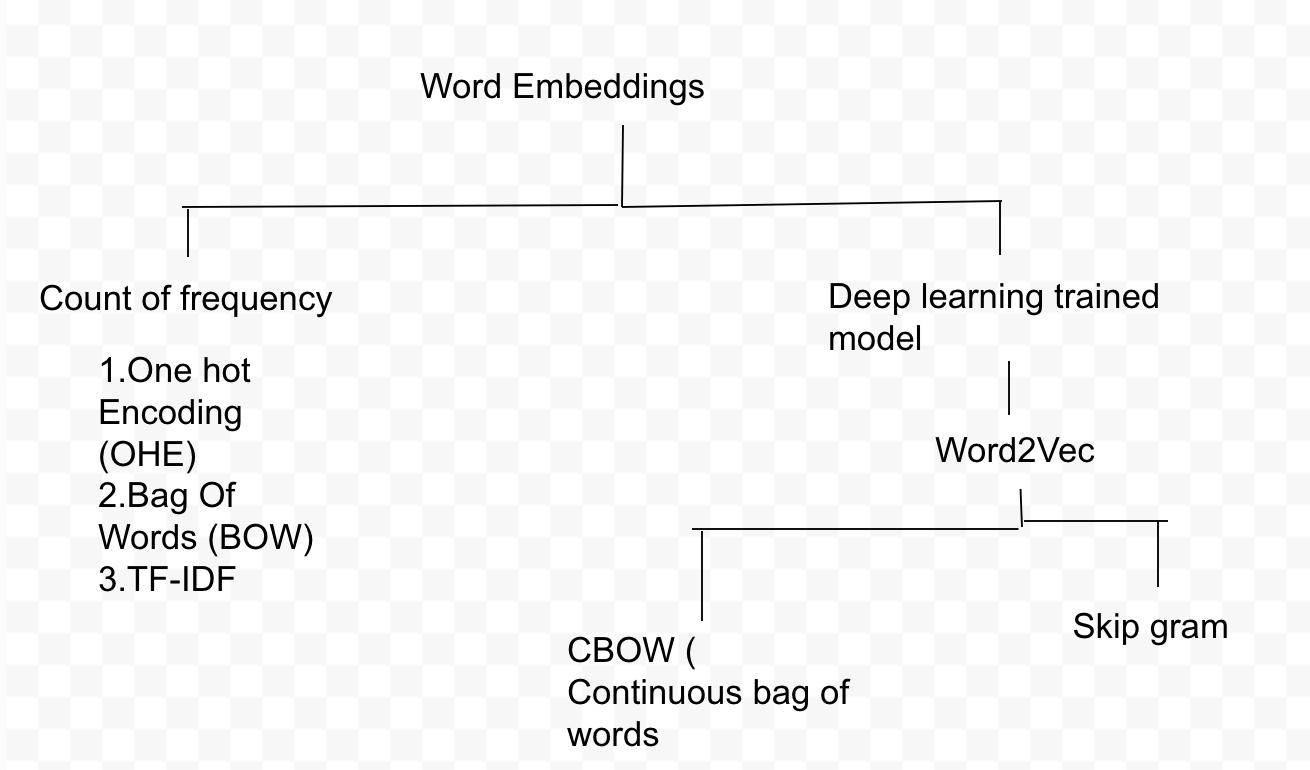


# ⭐ **Word2Vec**

*   A technique used in NLP published by Google in 2013. It uses neural network model to learn word associations from a large corpus of text.
*   Once train, such a model can detect synonymous words or suggest addidtional words for a partial sentence. As the name implied, word2vec represents each distinct word with a particular list of numbers called vector.
*   The model defines the similarity between the words by calculating the distance between the
vectors representing the words.
*   To understand how vectors calculations can predict words, we need to understand **cosine similarity**
*   **Cosine Similarity**: It calculate the cosine of the angle between 2 vectors.
                          **  Distance = 1 - cosine similarity **

1.   The closer the distance to 0, the closer in similarities/relations of the words to one another. As the distance is close to 1, it means that the words are not similar or weakly related.

2.   **Window size**: Important as it creates input data and output data.
  --> The window size is the **feature representation**, which means that when a word is converted to a vector, we will get 5 vectors in the output layer for each and every word.
  The **bigger** the window size, the **better** the model will perform
  For e.g: [iNeuron Company Is Related to Data Science]
            
          🔴 window size = 5 --> I select five words from the text
            take the center word, which is `Is`
      
      *  I/P: iNeuron,Company[Left side of center word]
            Related,To [Right side of the center word]
            --> words in forward context and words in backward context
         O/P: IS
    
      *   The next 5 words: [Company is Related to Data]
          *   Center word: Related
          *   Left, Right words: [Company, Is], [To, Data]
          *   O/P: Related

      *   The next round [Is Related to Data Science]
          *   Center word: To
          *   Left, Right words: [Is, Related], [Data, Science]
          *   O/P: To

--> The next step is to train the model based on this structure

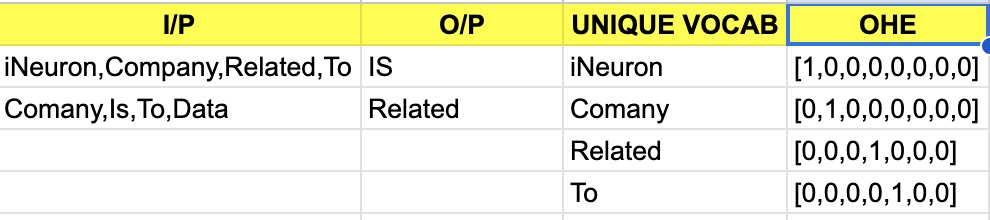


❗ We will convert each list of numerical representations into vector (each vector is 7 dimensions)

⭕ **CBOW**: Fully connected neural network [simple ANN]
  *   First layer: I/P layer. In this case, the I/P layer will have four words, each word will be presented by a 7-dimension vector
  *   Middle layer(Hidden layer): Window size = 5 -> 5 vectors
  *   Output layer: 7 different outputs, each output is one word in the sentence, and each word is reppresented by 7-dimension vector

❓ **How does this work**
  *   In ANN, each nueron in all the layers are connected to one another. Each connection is assigned a weight.

  *   Then the model is trained and predicted values are returned (forward propagation)
  
  *   The next step is to calculate the loss function (MSE, MAE,etc.) and try to minimize the loss function

  *   How can we minimize the loss function? We need to update/adjust the weights --> backward propagation. We continue doing this until the difference between y and y^hat is of minimal alue.












# **AvgWord2Vec**

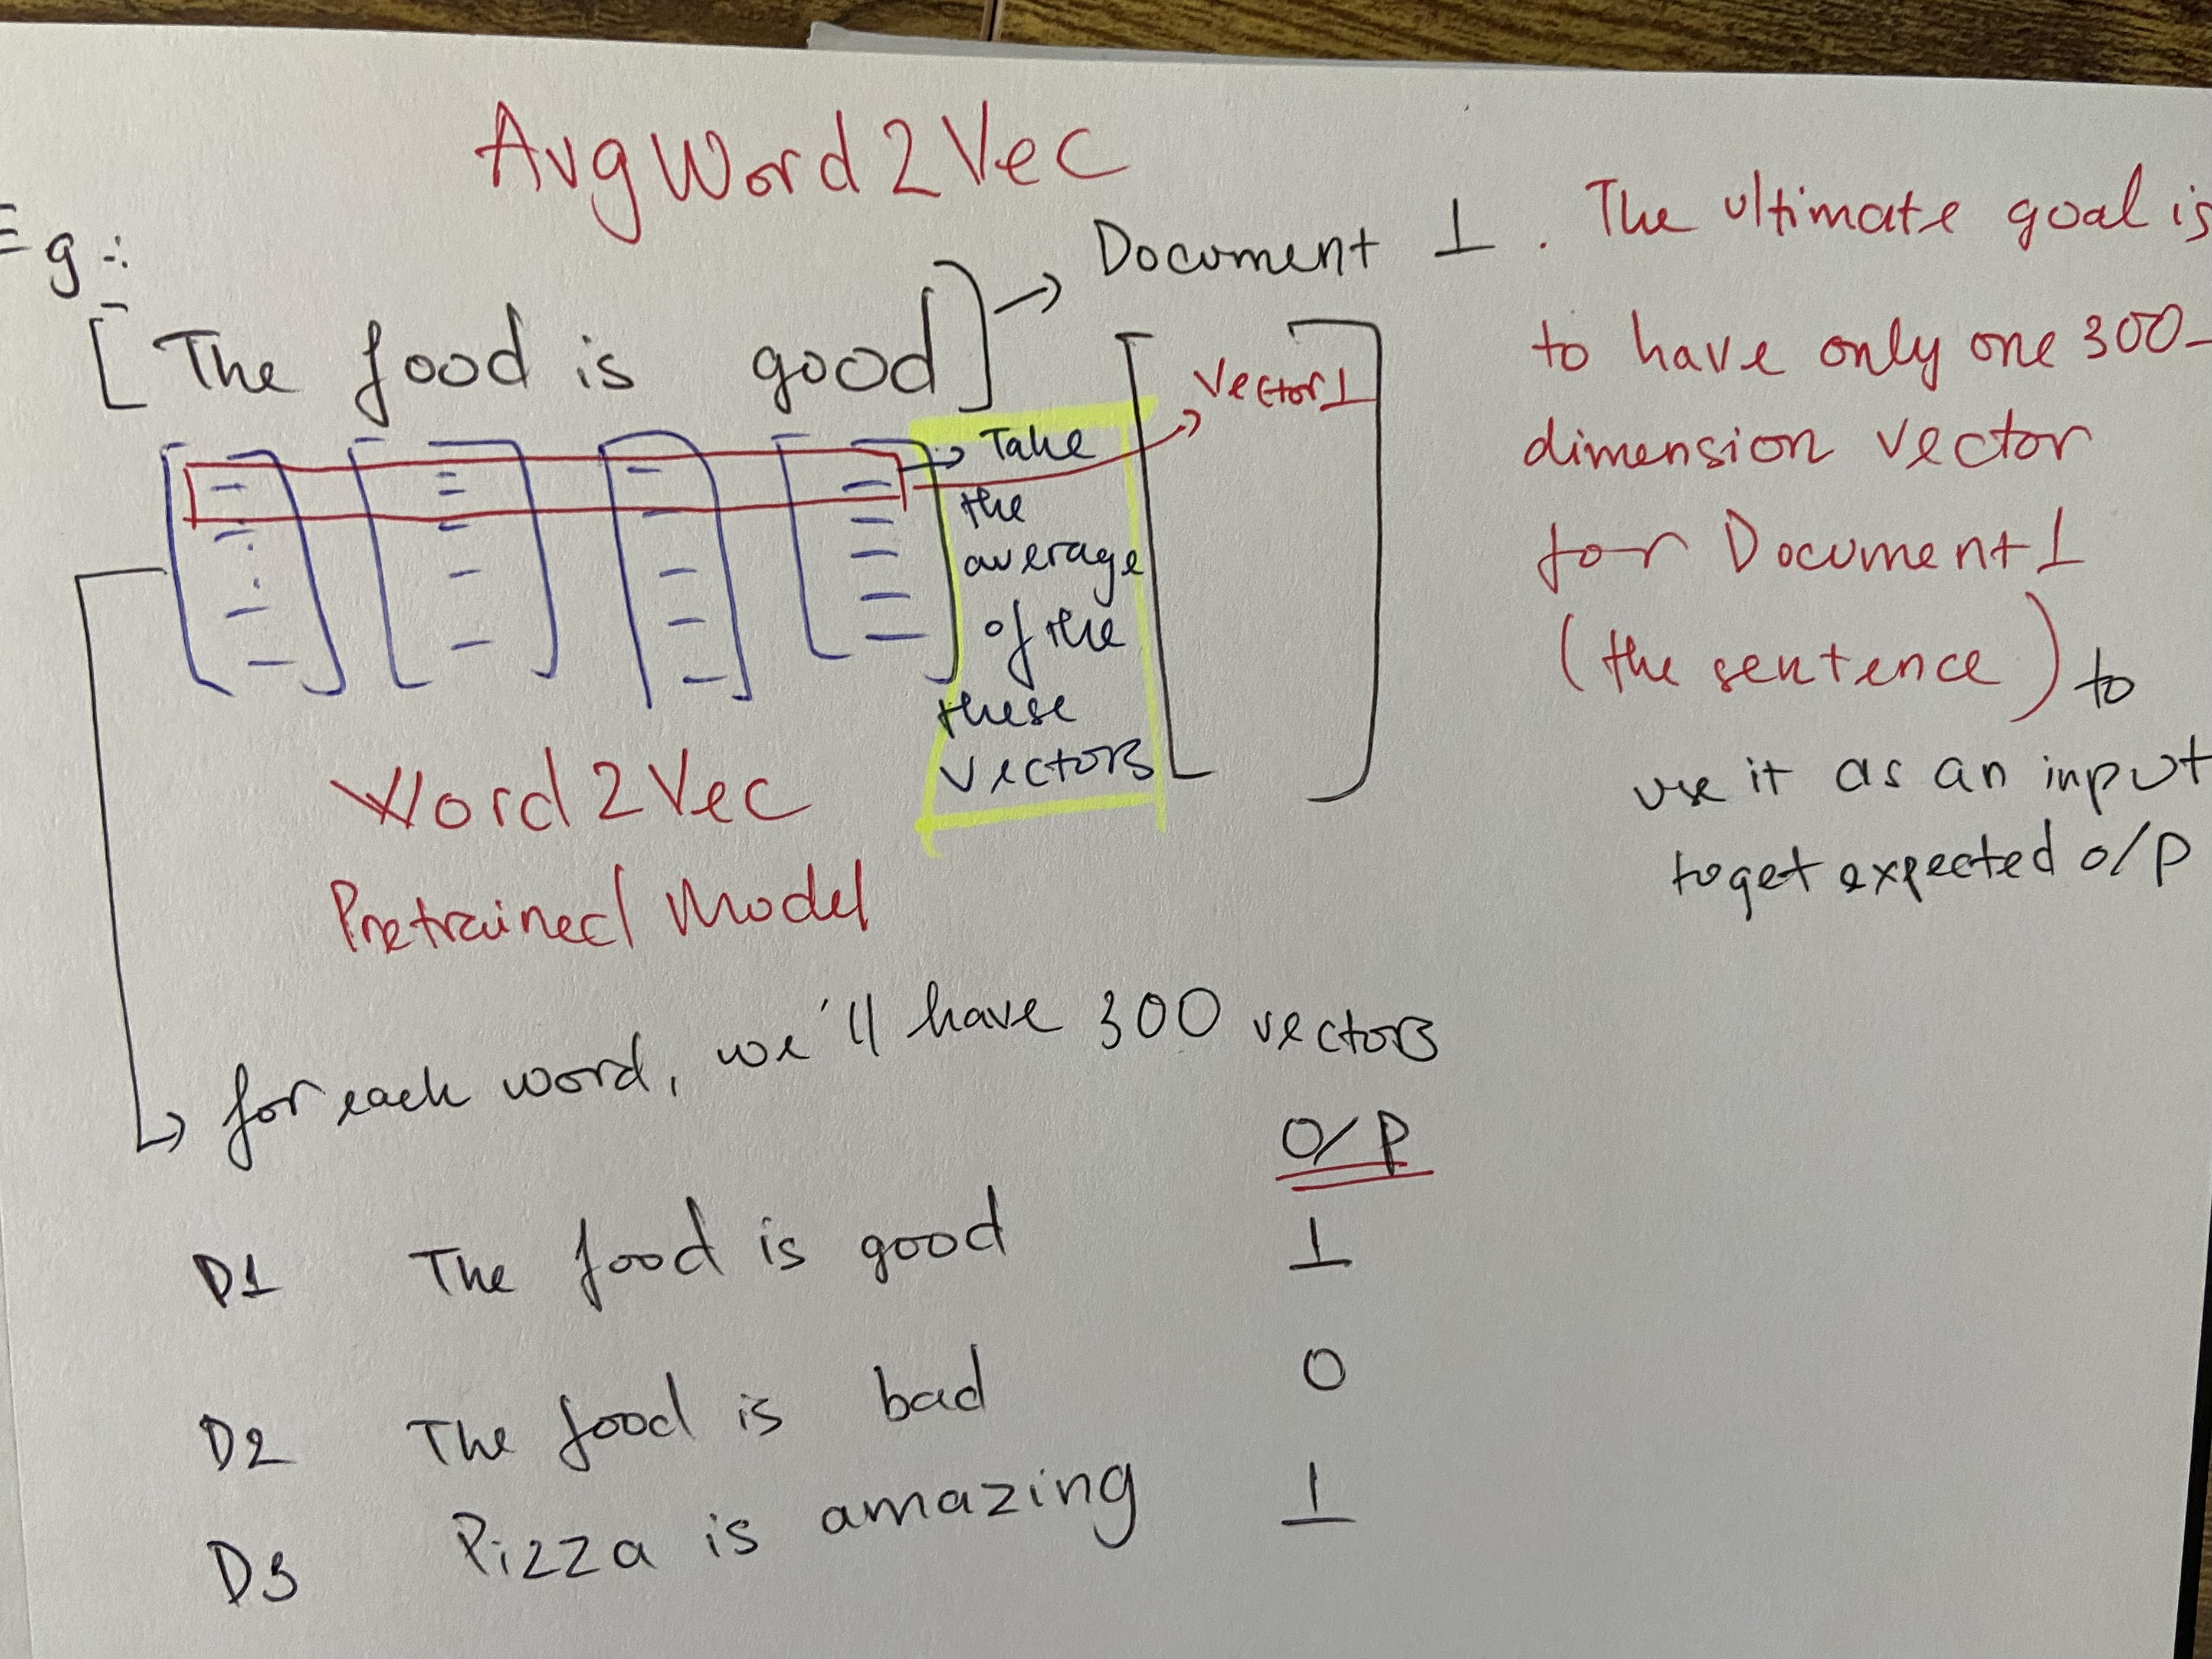

  

*   For classification problem, we need to use this method




In [ ]:
!pip install gensim

In [ ]:
import gensim
from gensim.models import Word2Vec, KeyedVectors


In [ ]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

vec_king = wv['king']

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
vec_king.shape

(300,)

**Word2Vec**
Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality'

In [55]:
import pandas as pd

In [57]:
data=pd.read_csv('/content/drive/MyDrive/ML DL AI/NLP/spam.csv',encoding='latin-1')

In [58]:
data.head()

,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [64]:
cols_to_keep = data.columns[:2]
data=data[cols_to_keep]

In [68]:
data.head(20)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [67]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [74]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [70]:
import re

In [75]:
corpus = []
for i in range(0, len(data)):
  review = re.sub('[^a-zA-Z]', ' ', data['message'][i])
  review = review.lower()
  review = review.split()

  review = [lemmatizer.lemmatize(word) for word in review]
  review = ' '.join(review)
  corpus.append(review)

In [76]:
corpus

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s',
 'u dun say so early hor u c already then say',
 'nah i don t think he go to usf he life around here though',
 'freemsg hey there darling it s been week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send to rcv',
 'even my brother is not like to speak with me they treat me like aid patent',
 'a per your request melle melle oru minnaminunginte nurungu vettam ha been set a your callertune for all caller press to copy your friend callertune',
 'winner a a valued network customer you have been selected to receivea prize reward to claim call claim code kl valid hour only',
 'had your mobile month or more u r entitled to update to the latest colour mobile with camera for free call the mobile up

In [78]:
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

In [81]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**simple_preprocess()**: convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long

In [83]:
words = []
for sent in corpus:
  sent_tokens = sent_tokenize(sent)
  for sent in sent_tokens:
    words.append(simple_preprocess(sent))


In [84]:
words

[['go',
  'until',
  'jurong',
  'point',
  'crazy',
  'available',
  'only',
  'in',
  'bugis',
  'great',
  'world',
  'la',
  'buffet',
  'cine',
  'there',
  'got',
  'amore',
  'wat'],
 ['ok', 'lar', 'joking', 'wif', 'oni'],
 ['free',
  'entry',
  'in',
  'wkly',
  'comp',
  'to',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  'st',
  'may',
  'text',
  'fa',
  'to',
  'to',
  'receive',
  'entry',
  'question',
  'std',
  'txt',
  'rate',
  'apply',
  'over'],
 ['dun', 'say', 'so', 'early', 'hor', 'already', 'then', 'say'],
 ['nah',
  'don',
  'think',
  'he',
  'go',
  'to',
  'usf',
  'he',
  'life',
  'around',
  'here',
  'though'],
 ['freemsg',
  'hey',
  'there',
  'darling',
  'it',
  'been',
  'week',
  'now',
  'and',
  'no',
  'word',
  'back',
  'like',
  'some',
  'fun',
  'you',
  'up',
  'for',
  'it',
  'still',
  'tb',
  'ok',
  'xxx',
  'std',
  'chgs',
  'to',
  'send',
  'to',
  'rcv'],
 ['even',
  'my',
  'brother',
  'is',
  'not',
  'like',
  'to',
  'spea

In [85]:
## Train the word2vec model from scratch

import gensim
model=gensim.models.Word2Vec(words)

In [87]:
# Getting all the vocabularies
model.wv.index_to_key

['you',
 'to',
 'the',
 'and',
 'it',
 'in',
 'is',
 'me',
 'my',
 'for',
 'your',
 'call',
 'of',
 'that',
 'have',
 'on',
 'now',
 'are',
 'can',
 'so',
 'but',
 'not',
 'or',
 'we',
 'do',
 'get',
 'at',
 'be',
 'if',
 'will',
 'ur',
 'with',
 'no',
 'just',
 'this',
 'gt',
 'lt',
 'go',
 'how',
 'up',
 'when',
 'ok',
 'day',
 'what',
 'free',
 'from',
 'all',
 'out',
 'know',
 'll',
 'come',
 'like',
 'time',
 'good',
 'then',
 'am',
 'got',
 'wa',
 'there',
 'he',
 'text',
 'only',
 'love',
 'want',
 'send',
 'txt',
 'need',
 'one',
 'today',
 'going',
 'by',
 'home',
 'don',
 'about',
 'stop',
 'she',
 'lor',
 'sorry',
 'see',
 'still',
 'mobile',
 'take',
 'back',
 'da',
 'reply',
 'our',
 'think',
 'dont',
 'tell',
 'week',
 'phone',
 'hi',
 'new',
 'later',
 'they',
 'any',
 'her',
 'pls',
 'ha',
 'please',
 'co',
 'did',
 'msg',
 'been',
 'min',
 'an',
 'some',
 'dear',
 'make',
 'here',
 'night',
 'message',
 'who',
 'say',
 'well',
 're',
 'where',
 'thing',
 'much',
 'grea

In [88]:
model.corpus_count

5569

In [89]:
model.epochs

5

*   The more epochs, the better the training model. However, too many epochs may take good amount of time



In [91]:
model.wv.similar_by_word('happy')

[('day', 0.9990674257278442),
 ('hope', 0.9987468123435974),
 ('dear', 0.9986814856529236),
 ('good', 0.998588502407074),
 ('morning', 0.9984720349311829),
 ('wish', 0.9984210729598999),
 ('well', 0.9984153509140015),
 ('fine', 0.9983962774276733),
 ('nice', 0.9983602166175842),
 ('amp', 0.9983365535736084)]

In [94]:
model.wv['good'].shape
# This is a 100-dimension vector

(100,)

In [95]:
words[0]
# Each word will have 100-dimension vector
# We want to average these vectors to get one single 100-dimension vector for this sentence

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'great',
 'world',
 'la',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

In [96]:
def avg_word2vec(doc):
  # remove out-of-vocab words
  # sent = [word for word in doc if word in model.wv.index_to_key]
  # print(sent)

  return np.mean([model.wv[word] for word in doc if word in model.wv.index_to_key])

In [97]:
!pip install tqdm

# Tqdm
 Tqdm package is one of the more comprehensive packages for progress bars with python and is handy for those instances you want to build scripts that keep the users informed on the status of your application.

In [99]:
from tqdm import tqdm

In [102]:
X = []
for i in tqdm(range(len(words))):
  X.append(avg_word2vec(words[i]))

100%|██████████| 5569/5569 [00:00<00:00, 5934.48it/s]


In [103]:
X

[0.0053275693,
 0.0036340058,
 0.0061424635,
 0.006191417,
 0.005721876,
 0.0069085197,
 0.0069714044,
 0.0062425244,
 0.008062404,
 0.008248758,
 0.0064681107,
 0.0075401235,
 0.008791237,
 0.0073303697,
 0.007467033,
 0.006494513,
 0.006547712,
 0.0051505226,
 0.007654925,
 0.0053712884,
 0.007984069,
 0.007454735,
 0.0051841275,
 0.004939211,
 0.0077387076,
 0.0048614605,
 0.007922642,
 0.007434109,
 0.0074382825,
 0.006771158,
 0.007954364,
 0.00738905,
 0.0072720093,
 0.008880001,
 0.0071757184,
 0.006382308,
 0.0057329517,
 0.007214285,
 0.0037274028,
 0.007328461,
 0.00665247,
 0.007820209,
 0.00844575,
 0.008631241,
 0.00919212,
 0.008698672,
 0.0067401864,
 0.0065125967,
 0.005350727,
 0.0061519933,
 0.0072036474,
 0.008013318,
 0.00615854,
 0.007939708,
 0.0062907054,
 0.008976805,
 0.0062871096,
 0.007450323,
 0.006796429,
 0.008027102,
 0.0073502595,
 0.0076862182,
 0.0050774245,
 0.005868462,
 0.004688924,
 0.0076316018,
 0.0066324496,
 0.007666968,
 0.007832644,
 0.007137

In [106]:
len(X) #Number of vector representations match the number of message in data

5569

In [111]:
# Turn X into independent features
X_new = np.array(X)
X_new.shape

(5569,)

In [119]:
# Dependent features
y=pd.get_dummies(data['label'],dtype=int)

In [120]:
y.iloc[:,0].values

array([1, 1, 0, ..., 1, 1, 1])

In [121]:
y.shape

(5572, 2)

*   There are a mismatch between the number of dependent and independent values (5569 and 5572, respectively). It's because we use reg-ex to preprocess data, so any message contains only number/symbols will be dropped


In [159]:
# We need to map y-values to match X

y = data[list(map(lambda x: len(x)>0, corpus))]
y=pd.get_dummies(y['label'],dtype=int)
y=y.iloc[:,0].values

y.shape

(5569,)

In [160]:
y

array([1, 1, 0, ..., 1, 1, 1])

In [161]:
X[2]

KeyError: 2

In [162]:
df_list = []
for i in range(0,len(X)):
  df_list.append(pd.DataFrame(X[i].reshape(-1,1)))
df = pd.concat(df_list,ignore_index=True)

AttributeError: 'Series' object has no attribute 'reshape'

In [163]:
df.shape

(5569, 1)

In [164]:
df.head()

,0
0,0.005328
1,0.003634
2,0.006142
3,0.006191
4,0.005722


In [165]:
X=df

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [168]:
X_train.head()

,0
5506,0.005884
5065,0.007421
1242,0.005622
4165,0.006733
5068,0.006009


In [169]:
y_train

array([1, 1, 1, ..., 0, 1, 1])

In [171]:
from sklearn.ensemble import RandomForestClassifier

In [172]:
rf = RandomForestClassifier()

In [175]:
df['Output']=y

In [176]:
df.head()

,0,Output
0,0.005328,1
1,0.003634,1
2,0.006142,0
3,0.006191,1
4,0.005722,1


In [190]:
df

,0,Output
0,0.005328,1
1,0.003634,1
2,0.006142,0
3,0.006191,1
4,0.005722,1
...,...,...
5564,0.008325,0
5565,0.006672,1
5566,0.007493,1
5567,0.006725,1


In [191]:
df = df.dropna()

In [195]:
df.isnull().sum()

,0
0,0
Output,0


In [196]:
df.shape

(5557, 2)

In [197]:
X = df

In [198]:
X.shape

(5557, 2)

In [199]:
y=df["Output"]

In [201]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [203]:
X_train.columns = X_train.columns.astype(str)

In [204]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [207]:
X_test.columns = X_test.columns.astype(str)

In [208]:
y_pred=rf.predict(X_test)

In [210]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_pred))

1.0


In [213]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      1.00      1.00       967

    accuracy                           1.00      1112
   macro avg       1.00      1.00      1.00      1112
weighted avg       1.00      1.00      1.00      1112



In [214]:
# This model has overfitting problem, we need to do hyperparameter tuning (ML topic discuessed later)